In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

from scipy.stats import binned_statistic_2d

data=pd.read_csv('yellow_tripdata_2016-05.csv', parse_dates=[1,2],
                usecols=range(7))

mask_dist=data.trip_distance>0

mask_time=(data.tpep_dropoff_datetime>data.tpep_pickup_datetime)

mask_long=((data.pickup_longitude>=-74.25559) & (data.pickup_longitude<=-73.70001))

mask_lat=((data.pickup_latitude>=40.49612) & (data.pickup_latitude<=40.91553))

mask_pas=data.passenger_count>0

df=data.loc[mask_dist & mask_long & mask_lat & mask_time & mask_pas]

df.tpep_pickup_datetime=df.tpep_pickup_datetime.dt.floor('1h')

regions=pd.read_csv('regions.csv', sep=';')

statistic = binned_statistic_2d(df['pickup_longitude'].values, 
                                   df['pickup_latitude'].values,
                                   df.passenger_count,            #### Тут может использоваться любой столбец
                                   statistic='count', 
                                  bins=[np.union1d(regions.west, regions.east), 
                                        np.union1d(regions.south, regions.north)], 
                                  expand_binnumbers=True)
                                  
df['region'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

agg=pd.DataFrame(index=np.unique(df.tpep_pickup_datetime), columns=regions.region.values)

def shape0(df):
    return df.shape[0]

a=df[['tpep_pickup_datetime', 'region', 'VendorID']].groupby(['tpep_pickup_datetime', 'region']).apply(shape0)

b=a.unstack()

b.fillna(0, inplace=True)

agg.fillna(0, inplace=True)

c=agg+b

c.fillna(0, inplace=True)

c=c.astype(int)

regions.index=regions.region
regions.drop(['region'], axis=1, inplace=True)

#### Пар час-ячейка без поездок

In [19]:
print(f'Ячеек без поездки было: {(c==0).sum().sum()}')

Ячеек без поездки было: 1718238


## Работа с геоданными

In [3]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [94]:
west=-74.25559
east=-73.70001
south=40.49612
north=40.91553

In [42]:
ESB_lat=40.7484
ESB_lon=-73.9857

### Empire state building

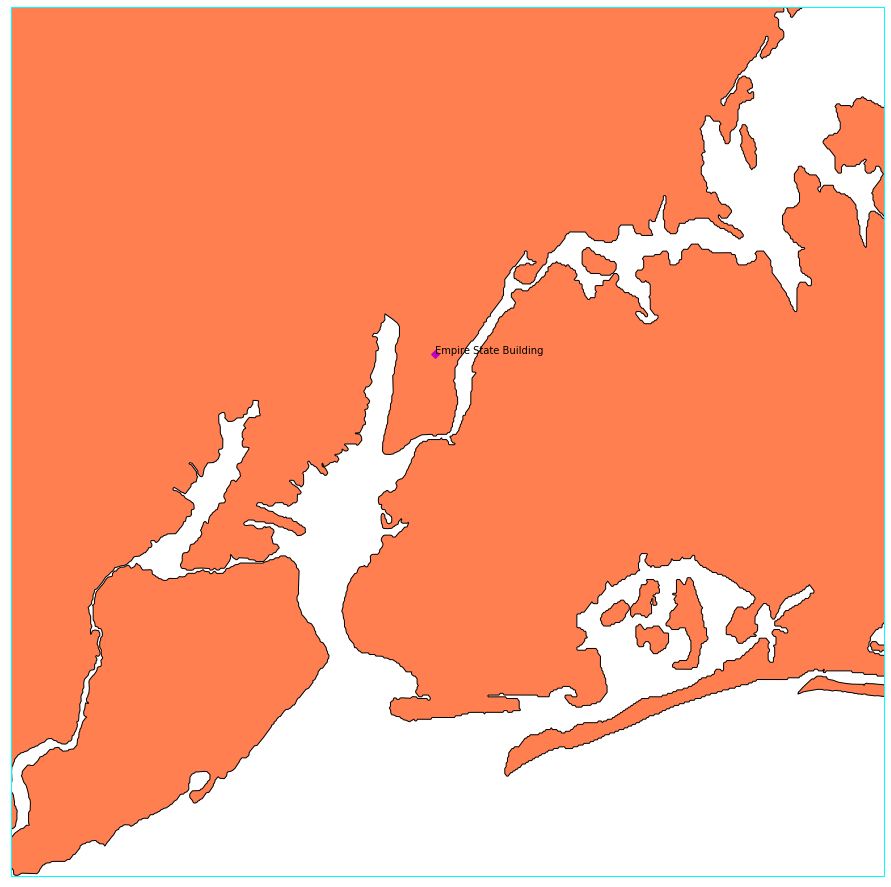

In [166]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
map = Basemap(projection='merc',
              resolution='f',
              lat_0=(north+south)/2, lon_0=(west+east)/2,
              llcrnrlon=west, llcrnrlat=south,
              urcrnrlon=east, urcrnrlat=north)


map.fillcontinents(color='coral',lake_color='aqua')
map.drawrivers()
map.drawmapboundary(color='aqua')
map.drawcoastlines()

x,y=map(ESB_lon, ESB_lat)
plt.plot(x,y, marker='D', color='m')
plt.text(x,y,'Empire State Building', fontsize=10)


plt.show()

### Добавим в таблицу regions данные о поездках из каждой ячейки за май

In [71]:
statistic[3]

array([[25, 24, 24, ..., 23, 25, 28],
       [33, 30, 30, ..., 27, 32, 11]], dtype=int64)

In [20]:
regions['v']=c.sum()

In [72]:
regions

west       east      south      north  v
region                                               
1      -74.255590 -74.244478  40.496120  40.504508  0
2      -74.255590 -74.244478  40.504508  40.512896  0
3      -74.255590 -74.244478  40.512896  40.521285  0
4      -74.255590 -74.244478  40.521285  40.529673  0
5      -74.255590 -74.244478  40.529673  40.538061  0
...           ...        ...        ...        ... ..
2496   -73.711122 -73.700010  40.873589  40.881977  0
2497   -73.711122 -73.700010  40.881977  40.890365  0
2498   -73.711122 -73.700010  40.890365  40.898754  0
2499   -73.711122 -73.700010  40.898754  40.907142  0
2500   -73.711122 -73.700010  40.907142  40.915530  0

[2500 rows x 5 columns]

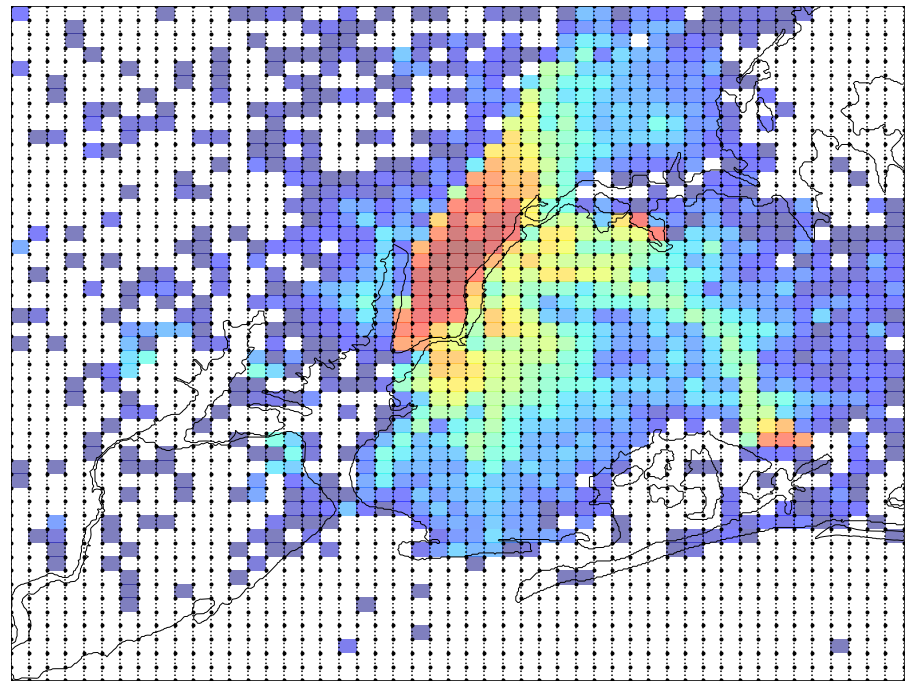

In [216]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
map = Basemap(projection='cyl',
              resolution='f',
              lat_0=(north+south)/2, lon_0=(west+east)/2,
              llcrnrlon=west, llcrnrlat=south,
              urcrnrlon=east, urcrnrlat=north)


map.drawcoastlines()

data=c.sum().values.reshape((50,50), order='F')

x = np.linspace(west, east, data.shape[1])
y = np.linspace(south, north, data.shape[0])

xx, yy = np.meshgrid(x, y)

plt.plot(xx, yy, color='black', marker='o', markersize=3, linestyle=':')

map.pcolormesh(xx, yy, np.log(data), cmap='jet', latlon=True, alpha=0.5)

plt.show()

## Интерактивные карты

In [10]:
import folium

In [97]:
m = folium.Map(location=[40.68, -74.04], zoom_start=12, tiles='stamentoner')

folium.Marker(
    location=[40.6892, -74.0445],
    popup="Statue of Liberty",
    icon=folium.Icon(icon="cloud"),
).add_to(m)
m

## Среднее количество поездок за час

In [45]:
regions['m']=c.mean()

In [81]:
new=pd.DataFrame(columns=['lat', 'long', 'm'], index=regions.index)

In [82]:
new.long=(regions.iloc[:,0]+regions.iloc[:,1])/2
new.lat=(regions.iloc[:,2]+regions.iloc[:,3])/2
new.m=regions['m'].values

In [53]:
from folium.plugins import HeatMap

In [84]:
m = folium.Map([40.6, -74.0], tiles="stamentoner", zoom_start=9.3)

HeatMap(new.values).add_to(m)

m

## Количество ячеек, из которых среднее количество поездок в час больше 5

In [87]:
print(f'Ячеек, из которых среднее количество поездок в час больше 5 : {np.where(new.m<5, 0, 1).sum()}')

Ячеек, из которых среднее количество поездок в час больше 5 : 102


## Проверим на карте

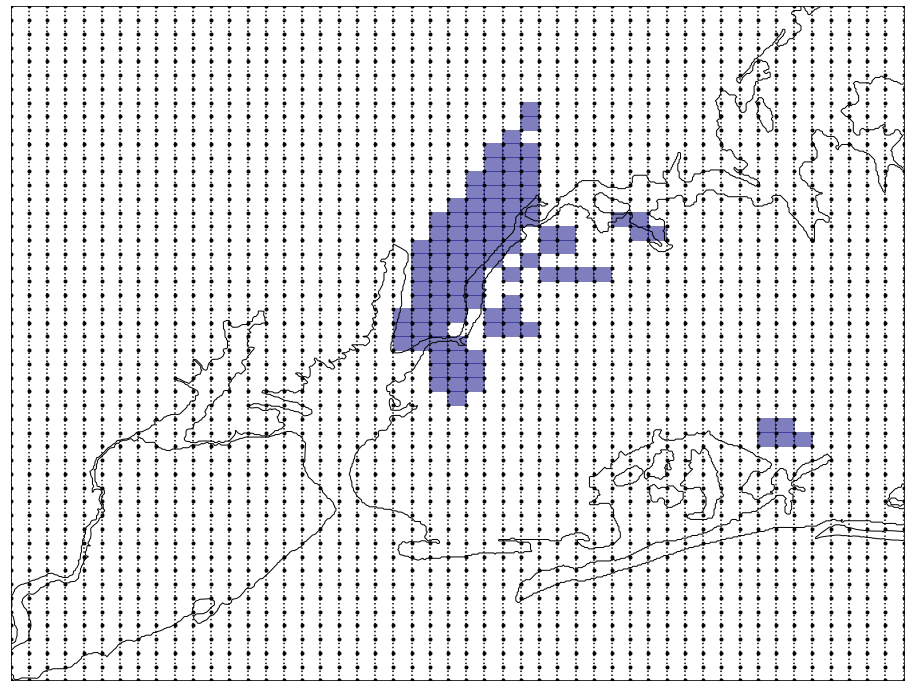

In [96]:
plt.figure(figsize=(16,16))
map = Basemap(projection='cyl',
              resolution='f',
              lat_0=(north+south)/2, lon_0=(west+east)/2,
              llcrnrlon=west, llcrnrlat=south,
              urcrnrlon=east, urcrnrlat=north)


map.drawcoastlines()

data=np.where(c.mean().values.reshape((50,50), order='F')<5, 0, 1)

x = np.linspace(west, east, data.shape[1])
y = np.linspace(south, north, data.shape[0])

xx, yy = np.meshgrid(x, y)

plt.plot(xx, yy, color='black', marker='o', markersize=3, linestyle=':')

map.pcolormesh(xx, yy, np.log(data), cmap='jet', latlon=True, alpha=0.5)

plt.show()

### Возможно есть 1-2 квдрата, из которых заказ невозможен, потому что они находятся на воде, однако все же небольшой участок суши захватывается, поэтому сказать трудно.